<a href="https://colab.research.google.com/github/matthewbegun/MXN500/blob/main/MXN500_2024_SOL_11_R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MXN500 Workshop 11 - Regression modelling

In [ ]:
#@title Imports
if (!require(pacman)) install.packages("pacman")
pacman::p_load(tidyverse, broom, GGally, patchwork)

Loading required package: pacman



In [ ]:
#@title Options
options(repr.plot.width=15, repr.plot.height=5, repr.plot.pointsize=24)

This week we will learn linear regression by examining some environmental data relating to air pollution in Piemonte Italy. This workshop gives experience in the main concepts throughout the semester, focussing on looking at how an outcome variable can change with multiple explanatory variables, transforming outcomes, making predictions, etc.

# Particulate matter in Piemonte

$\text{PM}_{10}$ is the concentration of particulate matter with a diameter of less than 10 $\mu\text{g}\,\text{m}^{-3}$, and is an air pollutant which is monitored in order to understand its health impact (Bell 2012).  Cameletti et al. (2012) give a full spatio-temporal analysis of a data set in Piemonte, Italy, looking at how $\text{PM}_{10}$ varies with spatial location, day of the year, and a number of meteorological variables.

A data set of observations provided via [Canvas](https://canvas.qut.edu.au/courses/17986/pages/week-11-regression-with-multiple-explanatory-variables). The variables correspond to:

| Short name | Description | Units |
| :--------- | :---------- | :---- |
| `Station.ID` | Station ID | None |
| `Date` | Calendar date | Year-Month-Day  |
| `A` | Altitude above sea level | $\text{m}$ |
| `UTMX` | Distance east of reference point | $\text{km}$ |
| `UTMY` | Distance north of reference point | $\text{km}$ |
| `WS` | Daily mean wind speed | $\text{m}\,\text{s}^{-1}$ |
| `TEMP` | Daily mean temperature | ${\,}^{\circ}\text{K}$ |
| `HMIX` | Daily maximum mixing height | $\text{m}$ |
| `PREC` | Daily precipitation | $\text{mm}$ |
| `EMI` | Daily emissions | $\text{g}\,\text{s}^{-1}$ |
| `PM10` | Daily mean $\text{PM}_{10}$ concentration | $\mu\text{g}\,\text{m}^{-3}$ |

**Exercise:** Download the data set and load the observation data set into R.

**Answer:**

In [ ]:
df <- read_csv('https://raw.githubusercontent.com/matthewbegun/MXN500/main/data/Piemonte_data_byday.csv')
df <- na.omit(df)
dim(df)
head(df)

Rows: 4368 Columns: 11
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): Date
dbl (10): Station.ID, A, UTMX, UTMY, WS, TEMP, HMIX, PREC, EMI, PM10

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] 4054   11

Station.ID,Date,A,UTMX,UTMY,WS,TEMP,HMIX,PREC,EMI,PM10
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,01/10/05,95.2,469.45,4972.85,0.90,288.81,1294.6,0,26.05,28
2,01/10/05,164.1,423.48,4950.69,0.82,288.67,1139.8,0,18.74,22
3,01/10/05,242.9,490.71,4948.86,0.96,287.44,1404.0,0,6.28,17
4,01/10/05,149.9,437.36,4973.34,1.17,288.63,1042.4,0,29.35,25
5,01/10/05,405.0,426.44,5045.66,0.60,287.63,1038.7,0,32.19,20
6,01/10/05,257.5,394.60,5001.18,1.02,288.59,1048.3,0,34.24,41


# Activity 1 -- Exploratory analysis

As we have many explanatory variables, we may wish to see how they are distributed, what the pairwise relationships are between them, and the strength of the linear relationships between them. It is common to take the log transform of $\text{PM}_{10}$, as it is a ratio variable which cannot take on a value less than 0 and is skewed.

**Exercise:** Make a new variable that contains the log of the $\text{PM}_{10}$ concentrations. Plot a histogram of it.

**Answer:**

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


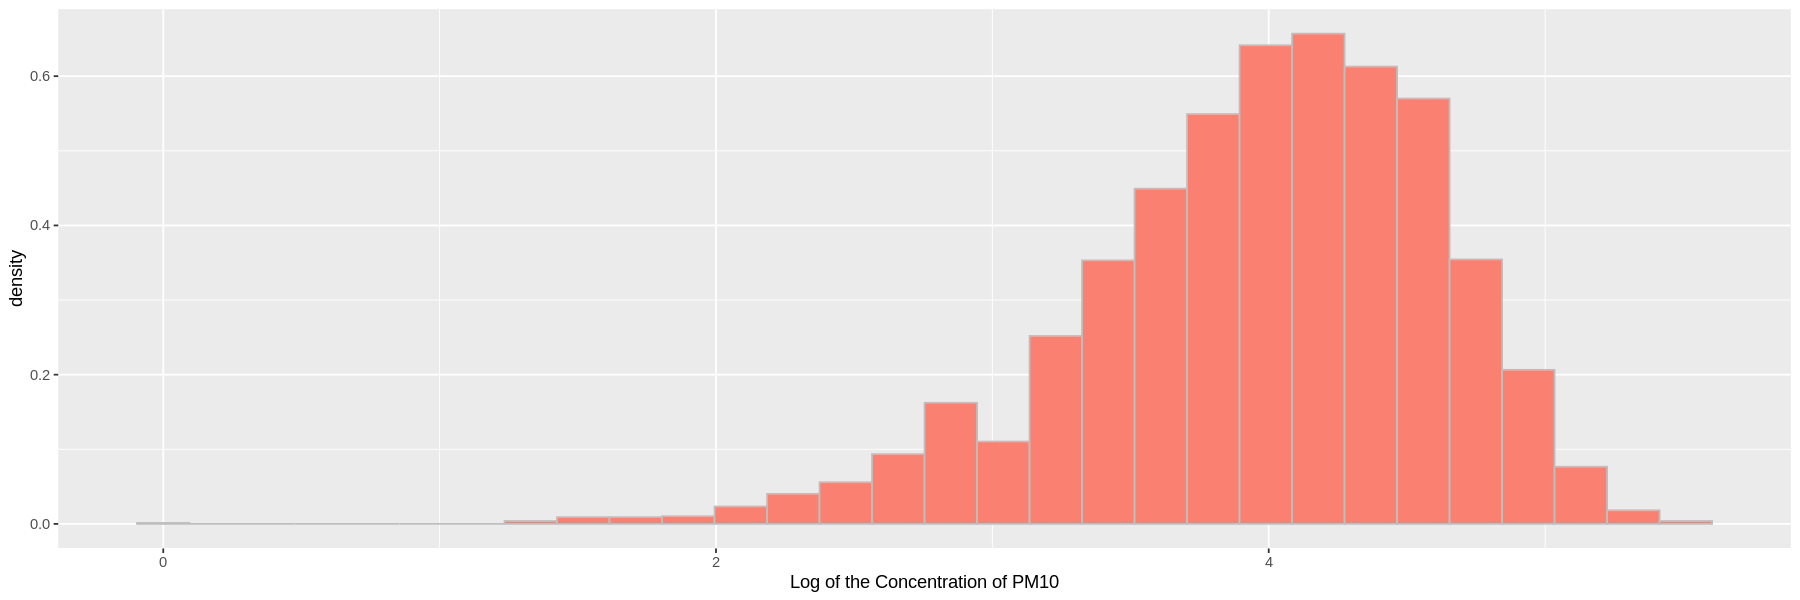

In [ ]:
df <- mutate(df, logPM10 = log(PM10))

ggplot(data = df, aes(x = logPM10, y = after_stat(density))) +
  geom_histogram(color = 'grey', fill = 'salmon') +
  scale_x_continuous(name = 'Log of the Concentration of PM10')


**Exercise:** Make a data frame that contains all of the explanatory variables in the data frame (except date and station ID) and the log-transformed $\text{PM}_{10}$ (do not include the untransformed $\text{PM}_{10}$). Using the `ggpairs()` function from `GGally`, make a pairs plot that shows how these variables are related.

**Answer:**

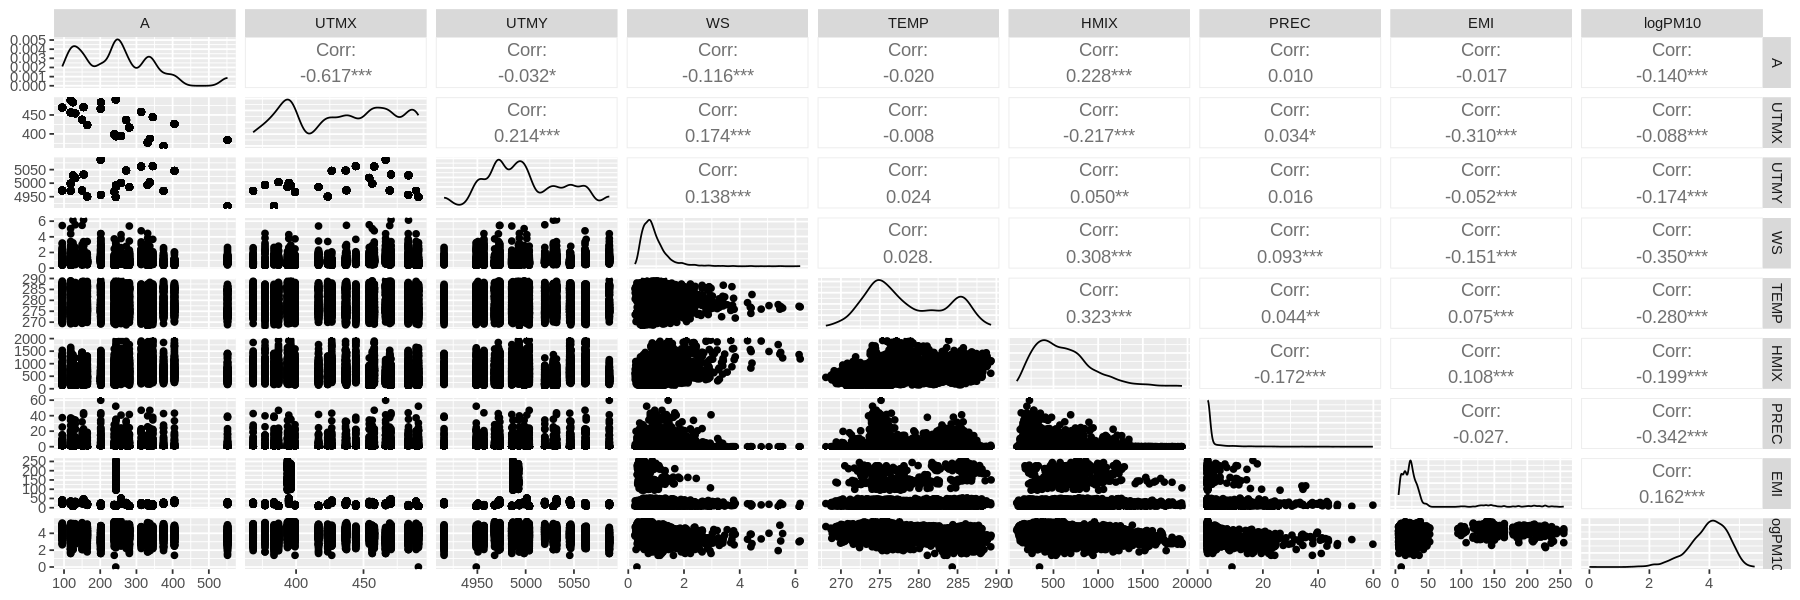

In [ ]:
df |>
  select(-one_of(c("Station.ID", "Date", "PM10"))) |>
  ggpairs()

**Exercise:** Which of the explanatory variables are most correlated with $\log (\text{PM}_{10})$?

**Answer:**

- WS = -0.350
- PREC = -0.342
- TEMP = -0.280


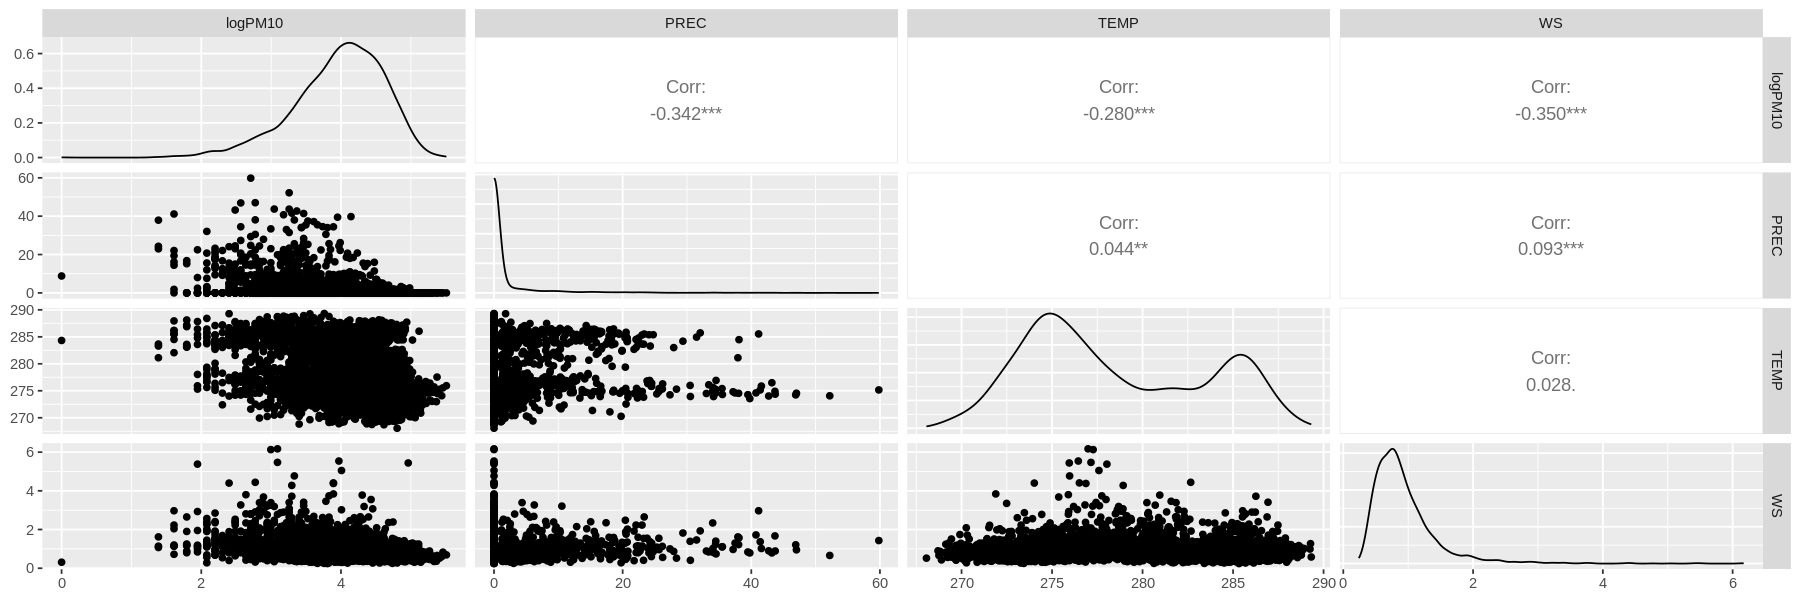

In [ ]:
df |>
    select("logPM10", "PREC", "TEMP", "WS") |>
    ggpairs()

**Exercise:** Are there any explanatory variables which are correlated with each other and may pose problems for us?

**Answer:** It appears that the potential explanatory variables identified are not correlated with each other, so there shouldn't be any issues.

**Exercise:** Are the spatial coordinates correlated with $\log (\text{PM}_{10})$? What would it mean if we included these as explanatory variables?

**Answer:** `UTMX` and `UTMY` do not appear to be correlated with `logPM10`. If we were to include these as explanatory variables, they should be considered categorical, as each is associated with a particular location.

**Exercise:** Remove the spatial coordinates from the data frame and use `ggpairs()` again to make the plot clearer.

**Answer:**

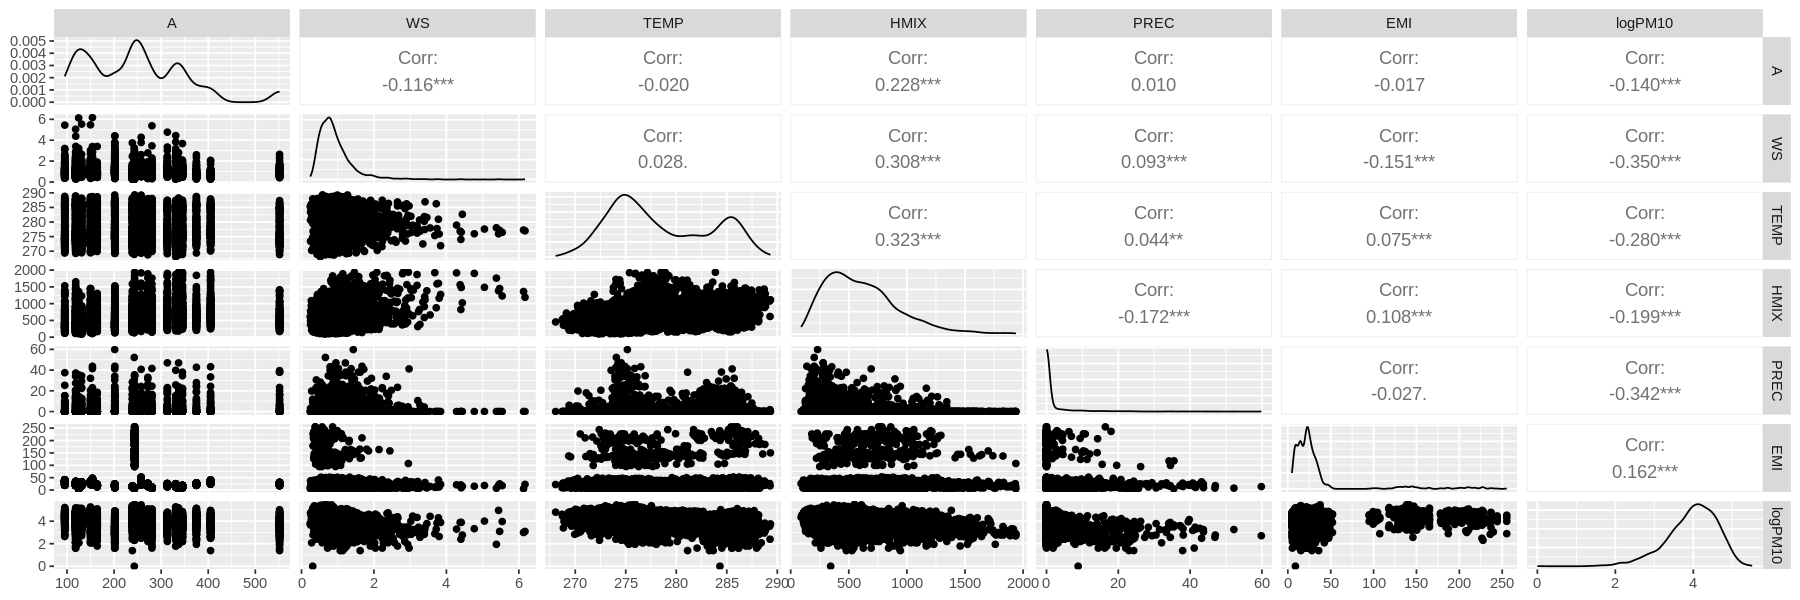

In [ ]:
df |>
  select(-one_of(c("Station.ID", "Date", "PM10", "UTMX", "UTMY"))) |>
  ggpairs()

# Activity 2 -- Regression model

## Fitting the model

**Exercise:** Fit a regression model of $\log (\text{PM}_{10})$ varying as a function of one of the covariates that you think explains a large proportion of the variability in the data. Show a table of the parameter estimates and their 95% confidence intervals below.

**Answer:**

In [ ]:
# tidy(lm1 <- lm(logPM10 ~ WS, df), conf.int=TRUE)
lm1 <- lm(logPM10 ~ WS, df)
tidy(lm1, conf.int=TRUE)

term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),4.3758686,0.01954848,223.84699,0.00000e+00,4.3375428,4.4141944
WS,-0.4325687,0.01819938,-23.76832,5.14555e-117,-0.4682495,-0.3968879


**Exercise:** How much variability in the data does this model explain?

**Answer:**

In [ ]:
# (-0.350)^2 <- rounded before operations, bad
cor(df$logPM10, df$WS)
cor(df$logPM10, df$WS)^2
summary(lm1)$r.squared
round(summary(lm1)$r.squared,4)


[1] -0.3498015

[1] 0.1223611

[1] 0.1223611

[1] 0.1224

**Exercise:** Is there evidence that the true value of the slope is not zero? In other words, is your explanatory variable having an effect on $\log (\text{PM}_{10})$?

**Answer:** Since the p-value is much less than $\alpha = 0.05$, there is very significant evidence against the hypothesis that `WS` has no effect on `logPM10`.

## Examining residuals

**Exercise:** Using the `augment()` function from the `broom` package (which is like `fortify()` and `bind_cols()` together), make a data frame that contains the original data and the regression diagnostics for that model. Plot the residuals against the fitted values.

**Answer:**

`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'


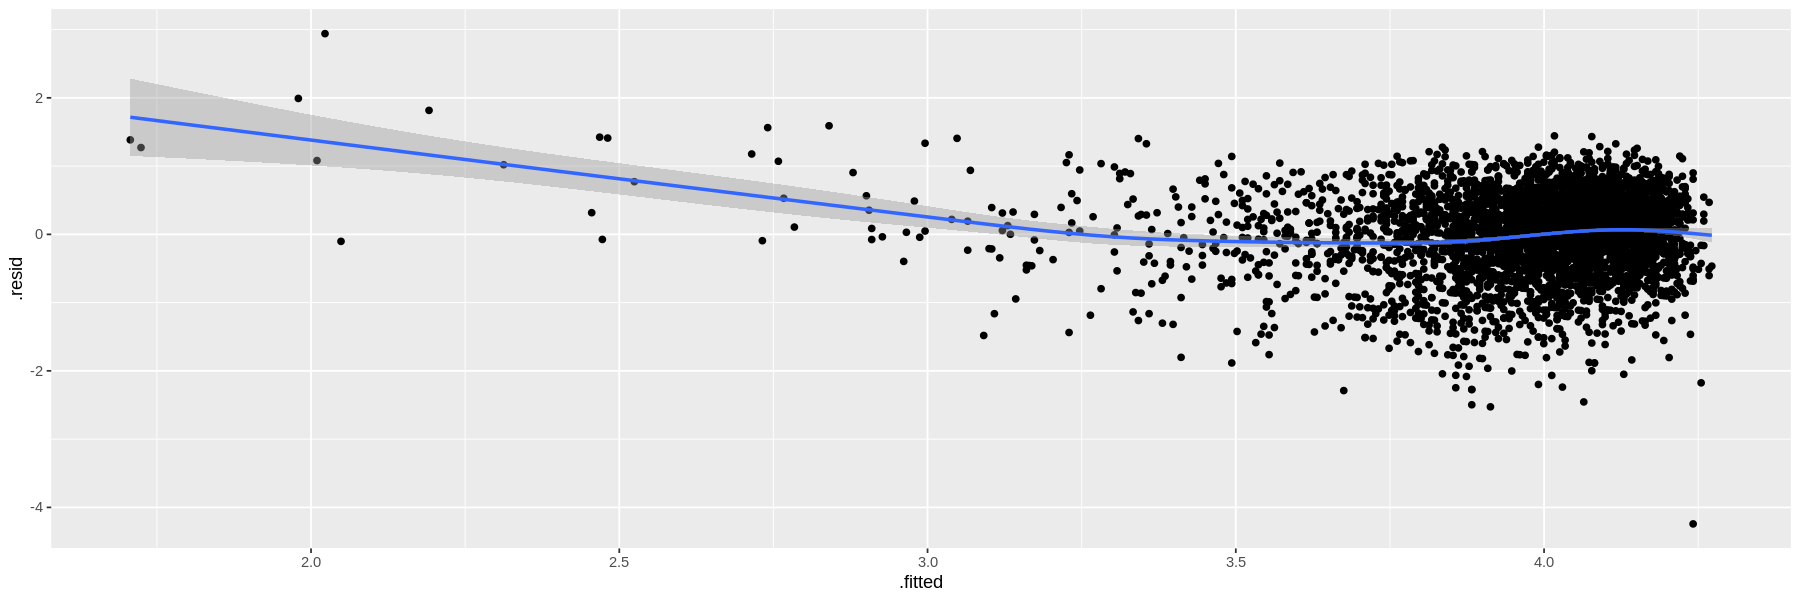

In [ ]:
lm1.aug <- augment(lm1, df)
ggplot(data  = lm1.aug, aes(x = .fitted, y = .resid)) +
  geom_point() +
  geom_smooth()



**Exercise:** Do the residuals appear to have a mean of 0 and a constant standard deviation?

**Answer:** The residuals do not appear to have a constant mean or a constant standard deviation. In fact, these residuals are really nasty!

**Exercise:** Create a qqplot of the standardised residuals.

**Answer:**

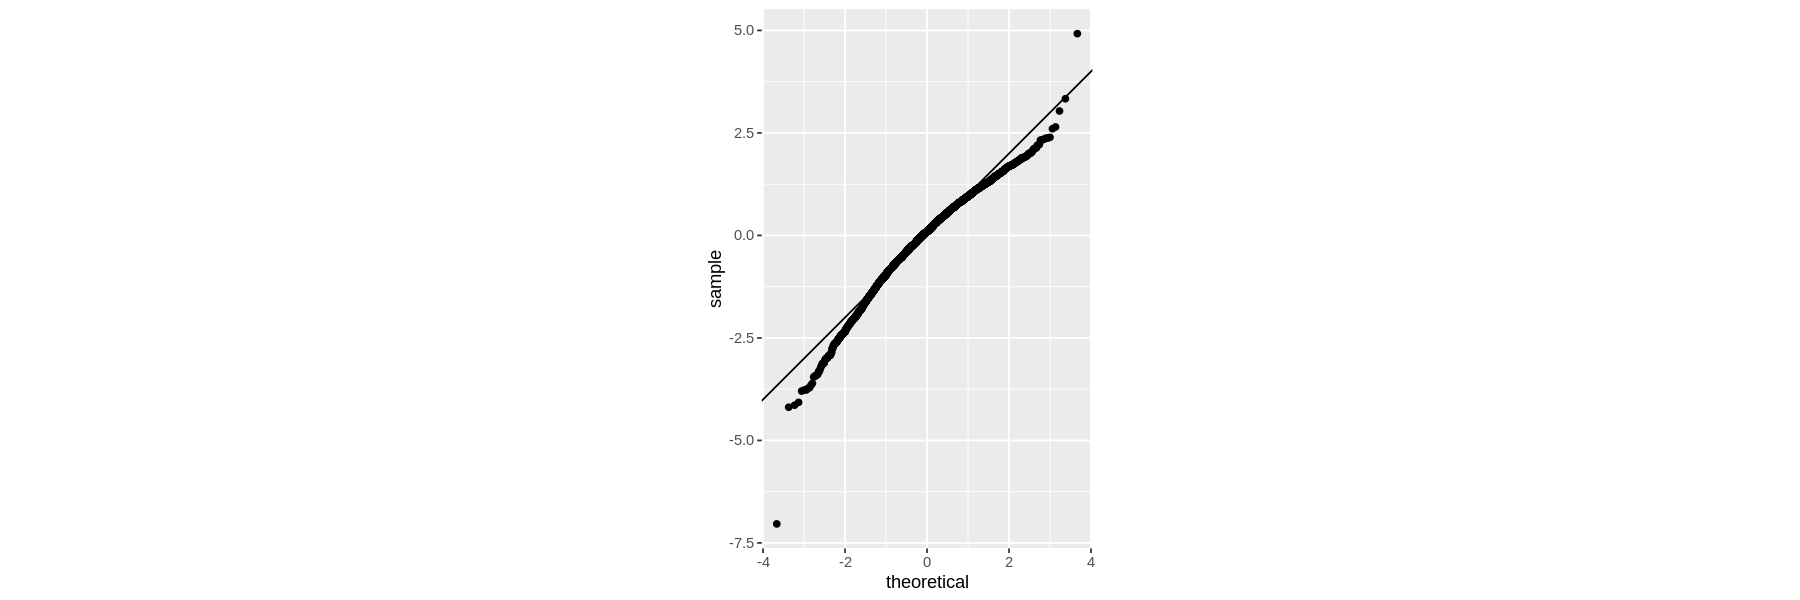

In [ ]:
ggplot(data = lm1.aug, aes(sample = .std.resid)) +
  stat_qq() +
  geom_abline() +
  coord_equal()

**Exercise:** Does this model satisfy the assumptions of linear regression?

**Answer:** No. The residuals are not homegeneous, and they are not normally distributed.

**Exercise:** Make a new data frame by selecting columns from the augmented data frame above. Make a pairs plot that shows how the residuals, `.resid`, and the explanatory variables not used in the regression model above are related to each other.

**Answer:**

`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'


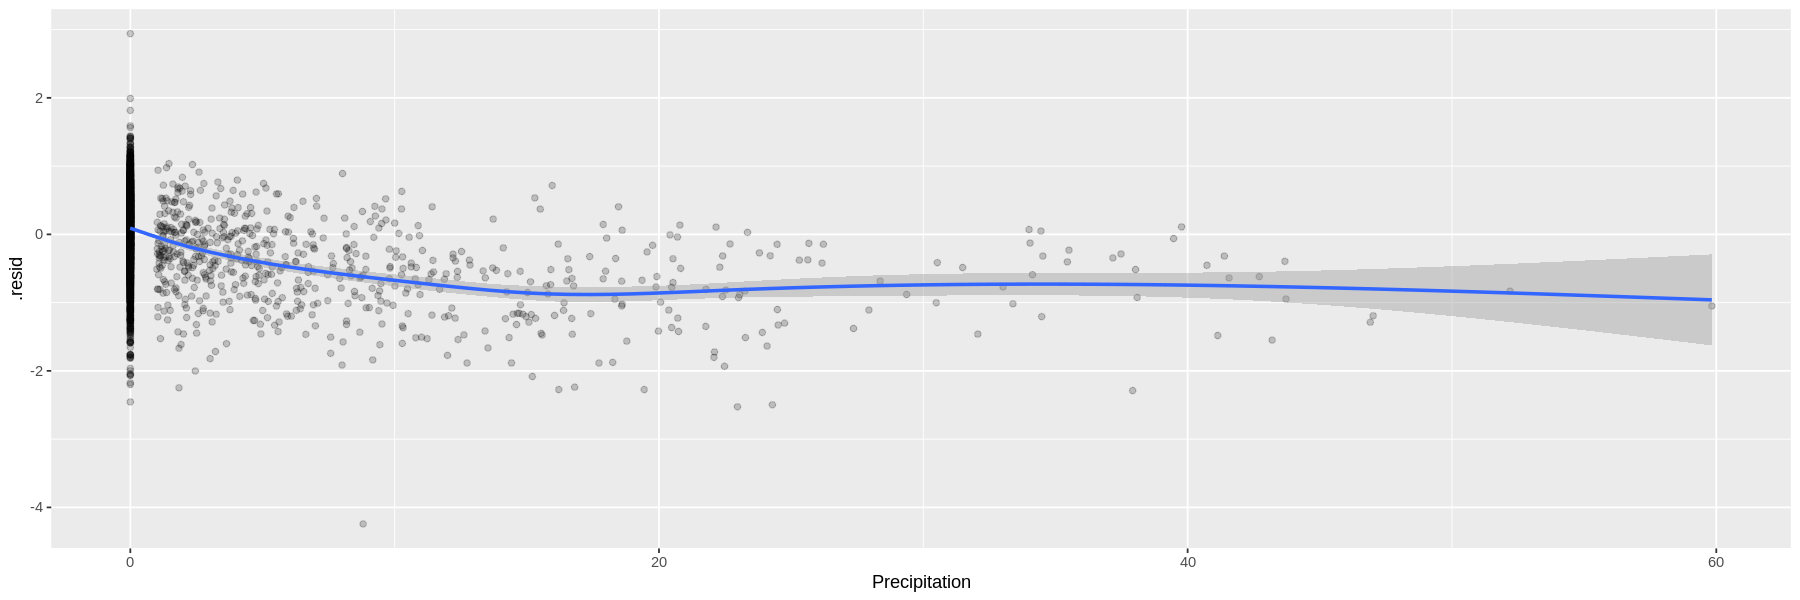

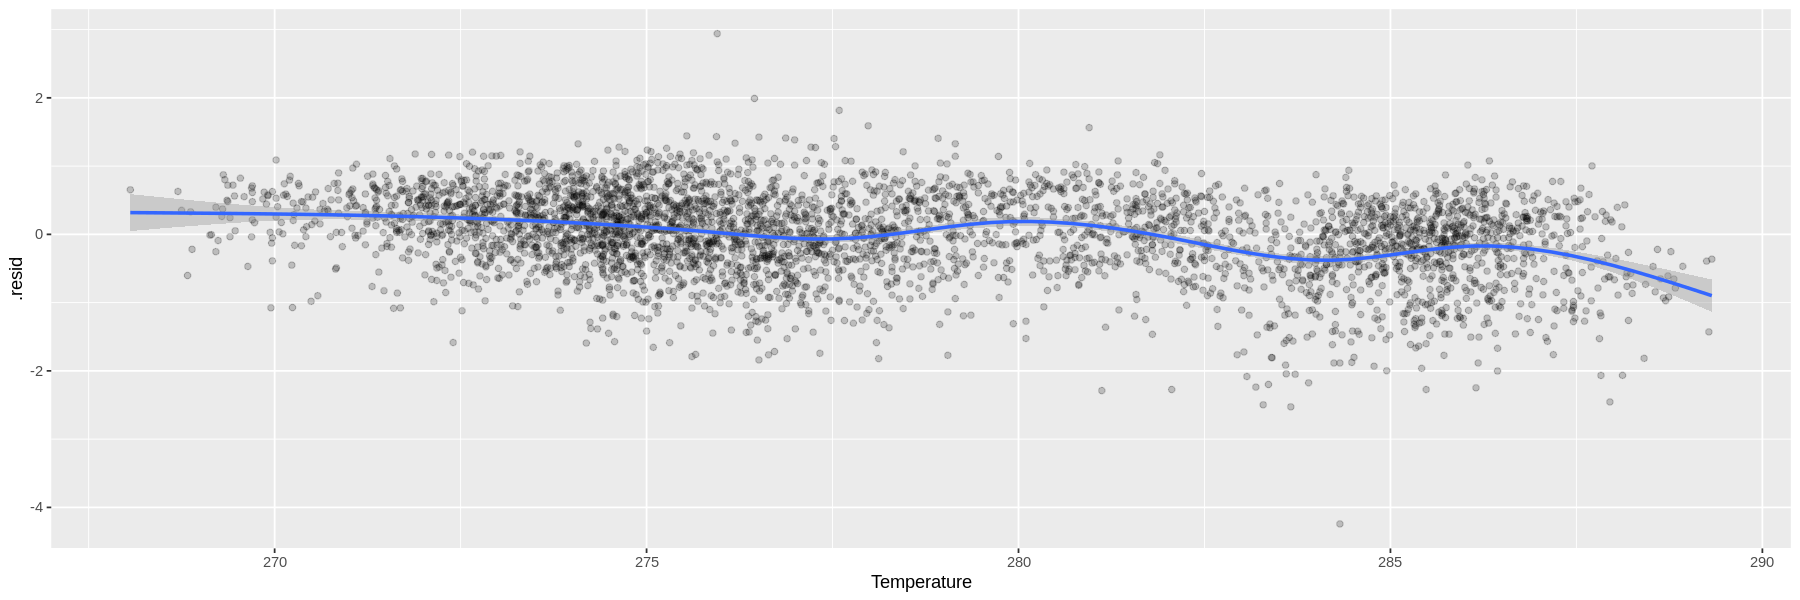

In [ ]:
ggplot(data = lm1.aug, aes( x = PREC, y = .resid))+
  geom_point(alpha = 0.2)+
  geom_smooth()+
  scale_x_continuous(name = "Precipitation")

ggplot(data = lm1.aug, aes( x = TEMP, y = .resid))+
  geom_point(alpha = 0.2)+
  geom_smooth()+
  scale_x_continuous(name = "Temperature")


**Exercise:** Which of the explanatory variables in the pairs plot seem to have the strongest relationship with the residuals from the previous model?

**Answer:** PREC

In [ ]:
round(cor(lm1.aug$.resid, lm1.aug$PREC),2)
round(cor(lm1.aug$.resid, lm1.aug$TEMP),2)


[1] -0.33

[1] -0.29

## Fitting a new model

**Exercise:** Make a new model, based on your original data frame with the log-transformed $\text{PM}_{10}$, that adds the explanatory variable identified in the above exercise to the model you fit before. Show a table of the parameter estimates and their 95% confidence intervals below.

**Answer:**

In [ ]:
tidy(lm2 <- lm(logPM10 ~ WS + PREC, df), conf.int=T)

term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),4.4007772,0.01847370,238.21855,0.000000e+00,4.36455857,4.43699577
WS,-0.3966923,0.01724206,-23.00725,3.436896e-110,-0.43049618,-0.36288835
PREC,-0.0396610,0.00176898,-22.42027,4.809766e-105,-0.04312917,-0.03619283


**Exercise:** How much variability in the data does this model explain?

**Answer:** Our new model explains 21.89% of the variability ($R^2 = 0.2189$).

In [ ]:
round(glance(lm2)$adj.r.squared,4)

[1] 0.2189

**Exercise:** Plot the residuals against the fitted values.

**Answer:**

`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'


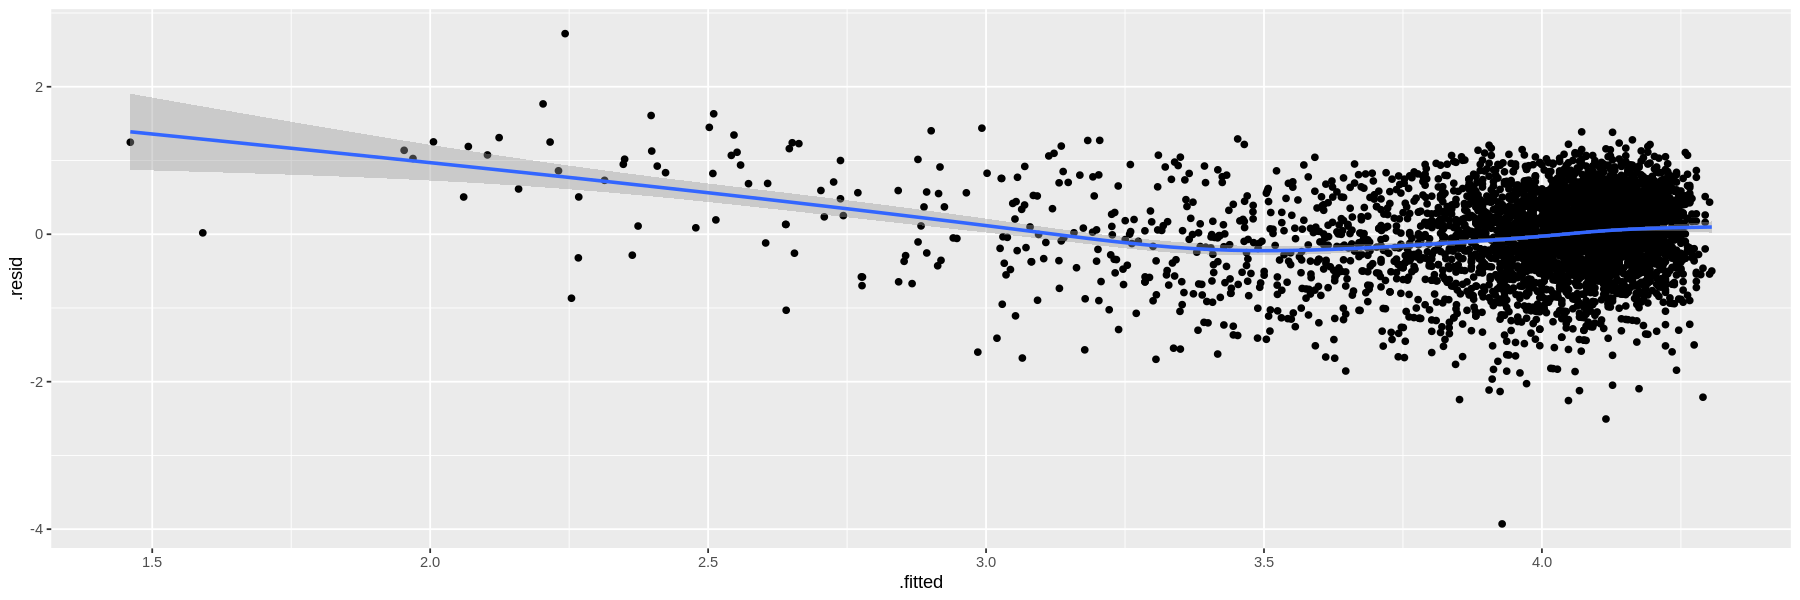

In [ ]:
lm2.aug <- augment(lm2, df)

ggplot(data  = lm2.aug, aes(x = .fitted, y = .resid)) +
  geom_point() +
  geom_smooth()

**Exercise:** Create a qqplot of the residuals.

**Answer:**

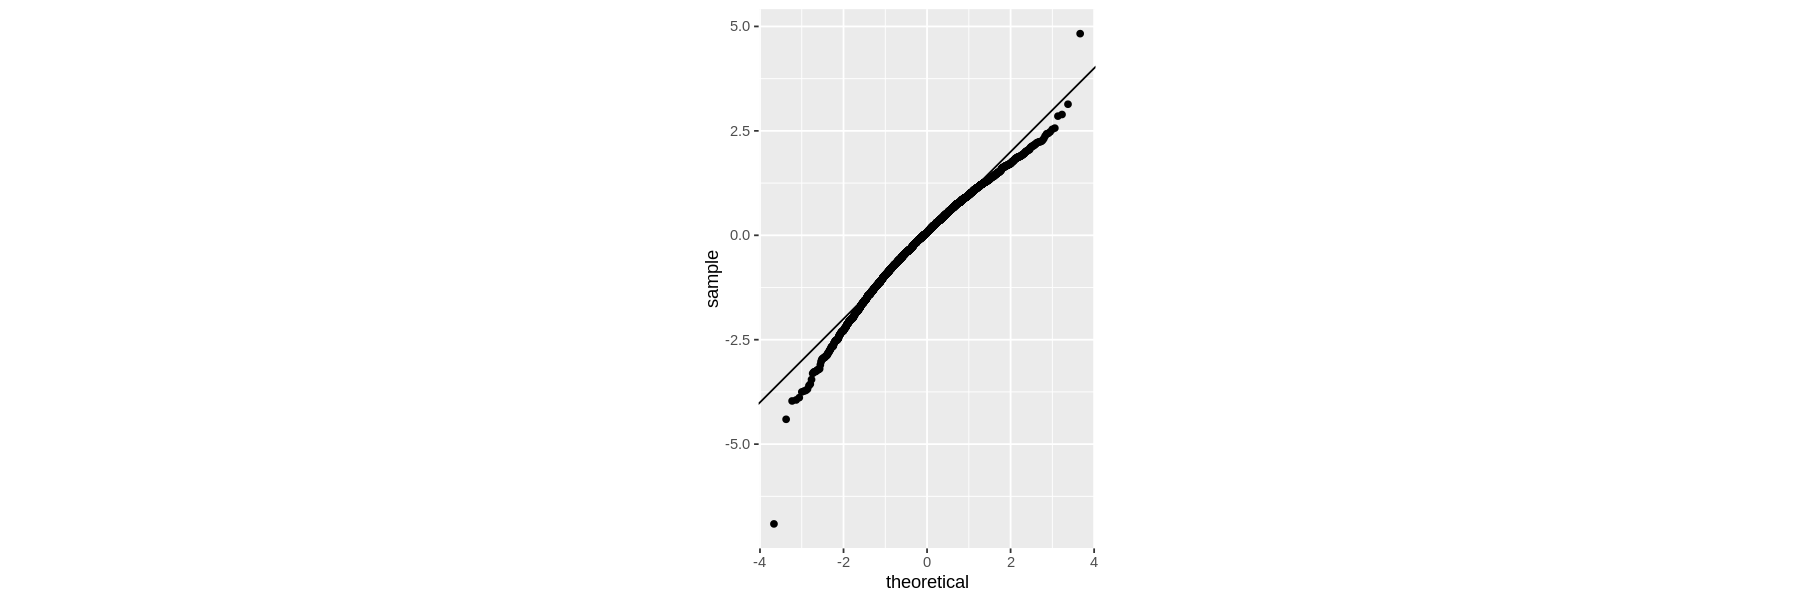

In [ ]:
ggplot(data = lm2.aug, aes(sample = .std.resid)) +
  stat_qq() +
  geom_abline() +
  coord_equal()

**Exercise:** Does this model satisfy the assumptions of linear regression?

**Answer:** No. The residuals do not appear to be homogeneous or Normally distributed.

**Exercise:** Perform an $F$ test with `anova()` to determine if adding this new variable to the regression model has a statistically significant effect in terms of improving the model fit. Discuss below.

**Answer:**

In [ ]:
anova(lm1, lm2)

,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,4052,1473.492,NA,NA,NA,NA
2,4051,1310.837,1,162.6552,502.6684,4.809766e-105


## Interaction terms

Let's examine if our two explanatory variables display interaction.


**Exercise:** Create a new model using `*` to include an interaction term in the regression.

**Answer:**

In [ ]:
tidy(lm3 <- lm(logPM10 ~ WS * PREC, df), conf.int=T)


term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),4.404208591,0.019068061,230.9730739,0.000000e+00,4.366824707,4.441592476
WS,-0.400134175,0.017881088,-22.3775078,1.133426e-104,-0.435190940,-0.365077411
PREC,-0.042624969,0.004443893,-9.5918083,1.464478e-21,-0.051337443,-0.033912495
WS:PREC,0.002560642,0.003521856,0.7270717,4.672241e-01,-0.004344133,0.009465417


**Exercise:** How much variability is explained by this model?

**Answer:**

In [ ]:
round(glance(lm2)$adj.r.squared,4)


[1] 0.2189

**Exercise:** Plot the residuals against the fitted values.

**Answer:**

`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'


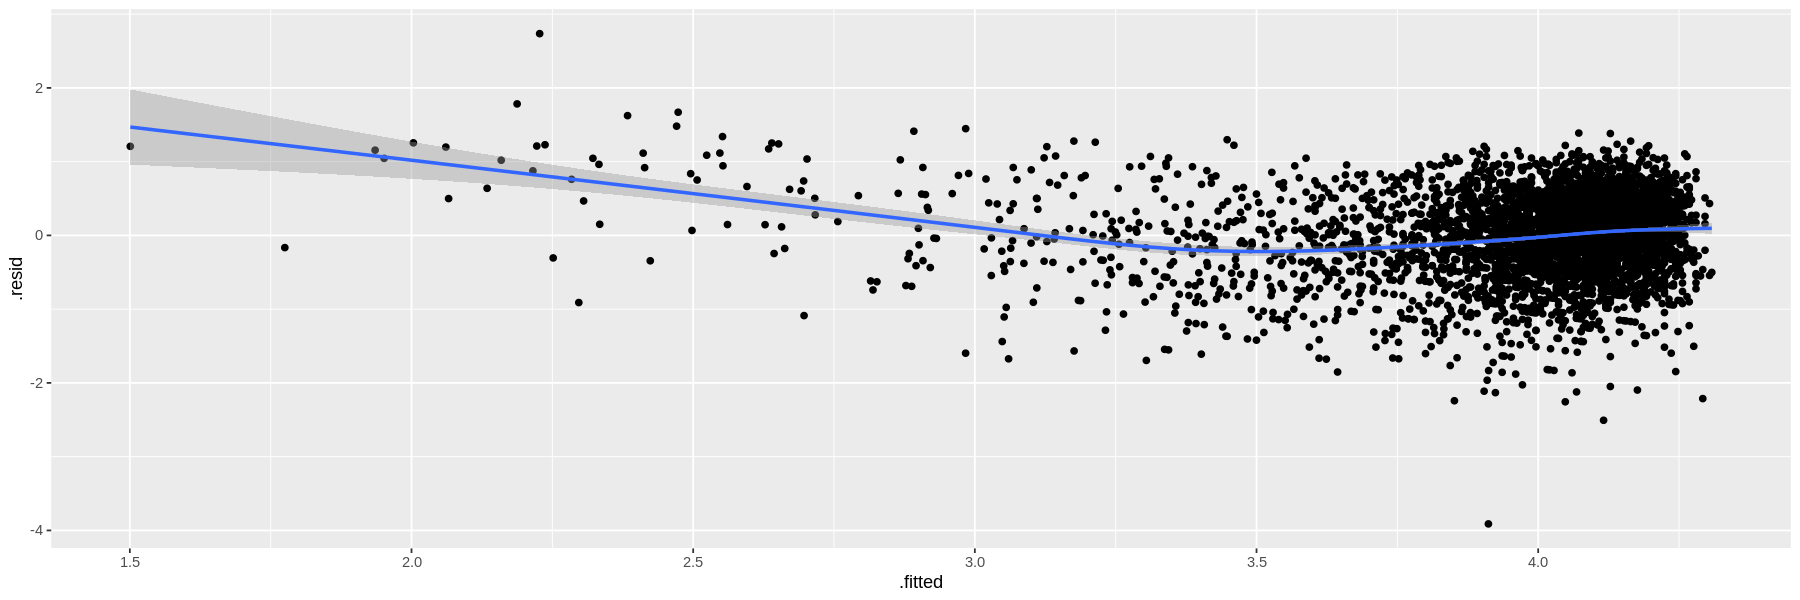

In [ ]:
lm3.aug <- augment(lm3, df)

ggplot(data  = lm3.aug, aes(x = .fitted, y = .resid)) +
  geom_point() +
  geom_smooth()

**Exercise:** Create a qqplot of the residuals.

**Answer:**

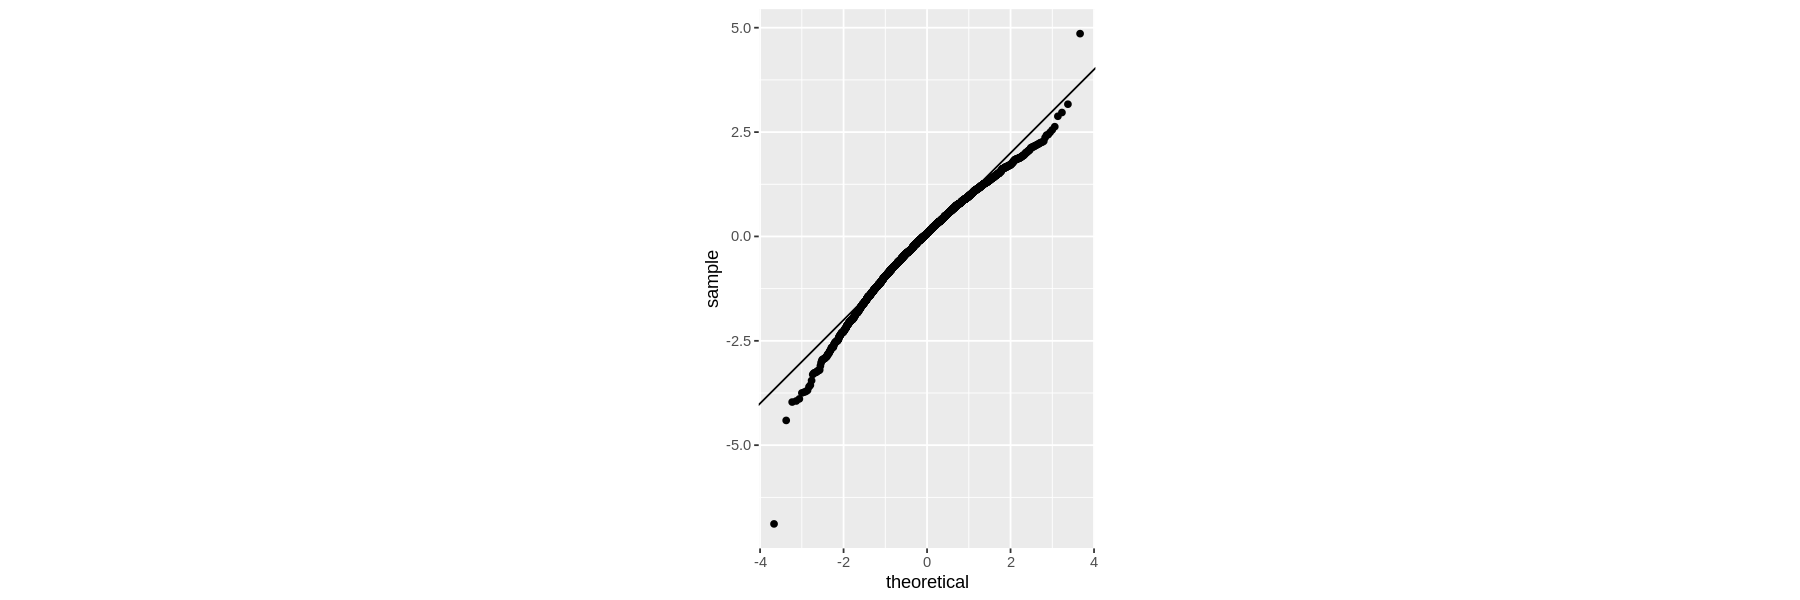

In [ ]:
ggplot(data = lm3.aug, aes(sample = .std.resid)) +
  stat_qq() +
  geom_abline() +
  coord_equal()

**Exercise:** Does this model satisfy the assumptions of linear regression?

**Answer:** This model still does not appear to satisfy the assumptions of linear regression.

**Exercise:** Perform an F-test to determine whether the model with the interaction term is better than the model without. What are the test-statistic, degrees of freedom, and p-value?

**Answer:**

In [ ]:
anova(lm2,lm3)

,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,4051,1310.837,NA,NA,NA,NA
2,4050,1310.665,1,0.1710769,0.5286333,0.4672241


**Exercise:** Is the interaction model better? Explain your answer.

**Answer:** There is insufficient evidence against the hypothesis that the models explain the same amount of variability in the data. So, the interaction model is no better than the other model.

# Activity 3 -- Using all explanatory variables


This iterative approach to model building is frequently used in practice when there are many explanatory variables and it is not clear which ones should be included and which should be excluded. The technique of successively adding explantory variables is found in stepwise regression (Hastie and Pregibon 1992; Venables and Ripley 2002) and least angle regression (Tibshirani et al. 2004), two techniques which are outside the scope of MXN500. Rather than adding one at a time manually or checking every combination of explanatory variables, we will fit the model with all explanatory variables and determine if there are any which may not be necessary.


**Exercise:** Fit a model that that models $\log (\text{PM}_{10})$ as a function of wind speed, temperature, mixing height, emissions, precipitation and altitude. Include a table below of parameter estimates, 95% confidence intervals, and $p$ values from the hypothesis test that the effect of that variable is 0.

**Answer:**

In [ ]:
tidy(lm4 <- lm(logPM10 ~ WS + TEMP + HMIX + EMI + PREC + A, df), conf.int=T)


term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),13.7409062408,4.973394e-01,27.628833,4.431971e-154,12.7658473887,1.471597e+01
WS,-0.3651490811,1.778212e-02,-20.534622,3.221564e-89,-0.4000118191,-3.302863e-01
TEMP,-0.0327730868,1.793150e-03,-18.276826,9.078290e-72,-0.0362886472,-2.925753e-02
HMIX,-0.0001164017,3.177504e-05,-3.663306,2.521672e-04,-0.0001786983,-5.410514e-05
EMI,0.0019401318,1.944792e-04,9.976036,3.586239e-23,0.0015588455,2.321418e-03
PREC,-0.0391434168,1.693291e-03,-23.116770,3.725044e-111,-0.0424631989,-3.582363e-02
A,-0.0009761401,8.312729e-05,-11.742716,2.468367e-31,-0.0011391153,-8.131649e-04


**Exercise:** How much of the variability in the data does this model explain?

**Answer:** Since $R^2=0.3337$ the model explains 33.37% of the variability in the data.

In [ ]:
round(glance(lm4)$adj.r.squared,4)

[1] 0.3337

**Exercise:** At a significance level of $\alpha = 0.05$ (corresponding to a 95% confidence interval), are there any explanatory variables which ~~have an effect indistinguishable from zero~~ are not significant?

**Answer:** No, all the variables have $p < \alpha$

**Exercise:** Augment the data frame used to fit this model with the diagnostics from the model itself. Plot the residuals against the fitted values. Do they have a mean of 0 and constant standard deviation?

**Answer:** No, but this model is much closer to satisfying the assumptions of linear regression than our previous models.

`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'


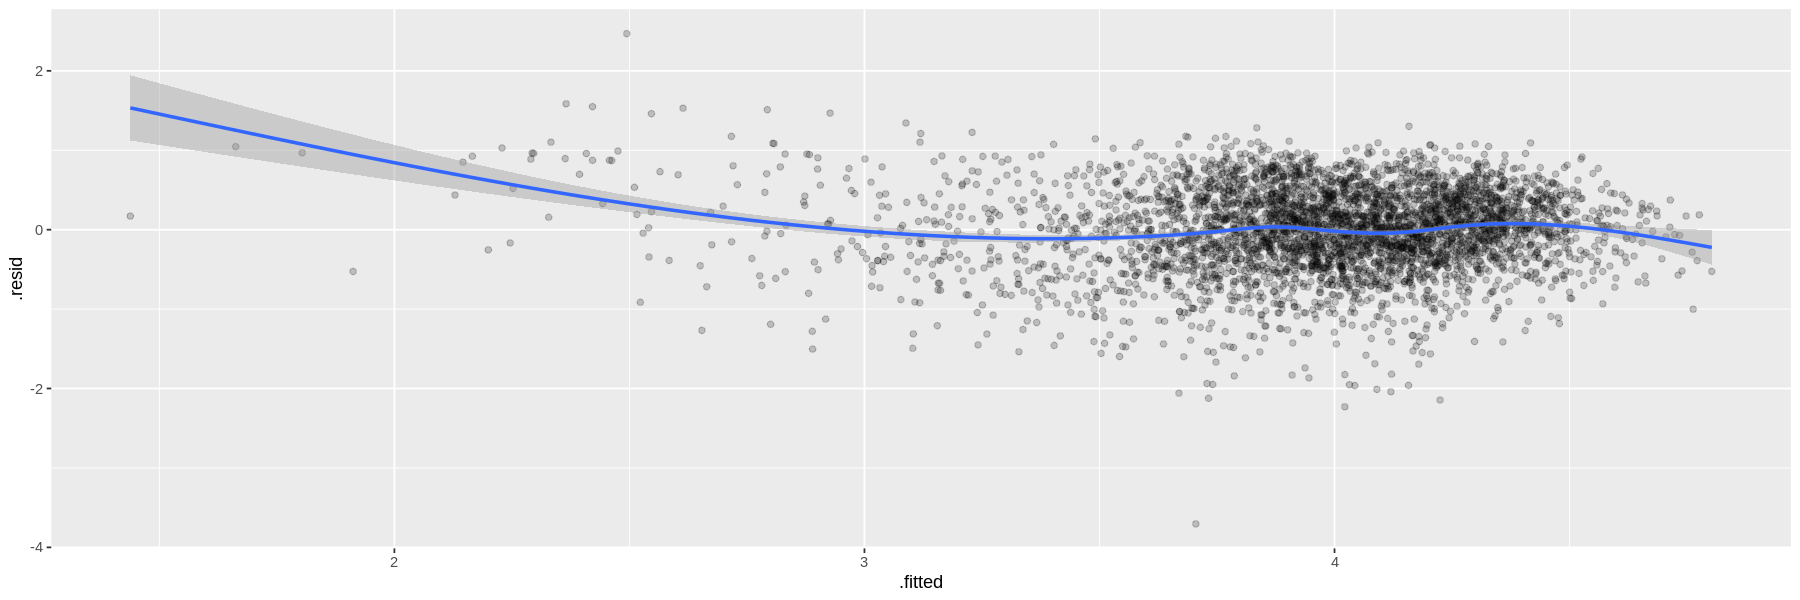

In [ ]:
lm4.aug <-augment(lm4, df)

ggplot(data = lm4.aug, aes(x = .fitted, y = .resid)) +
  geom_point(alpha = 0.2) +
  geom_smooth()

`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'


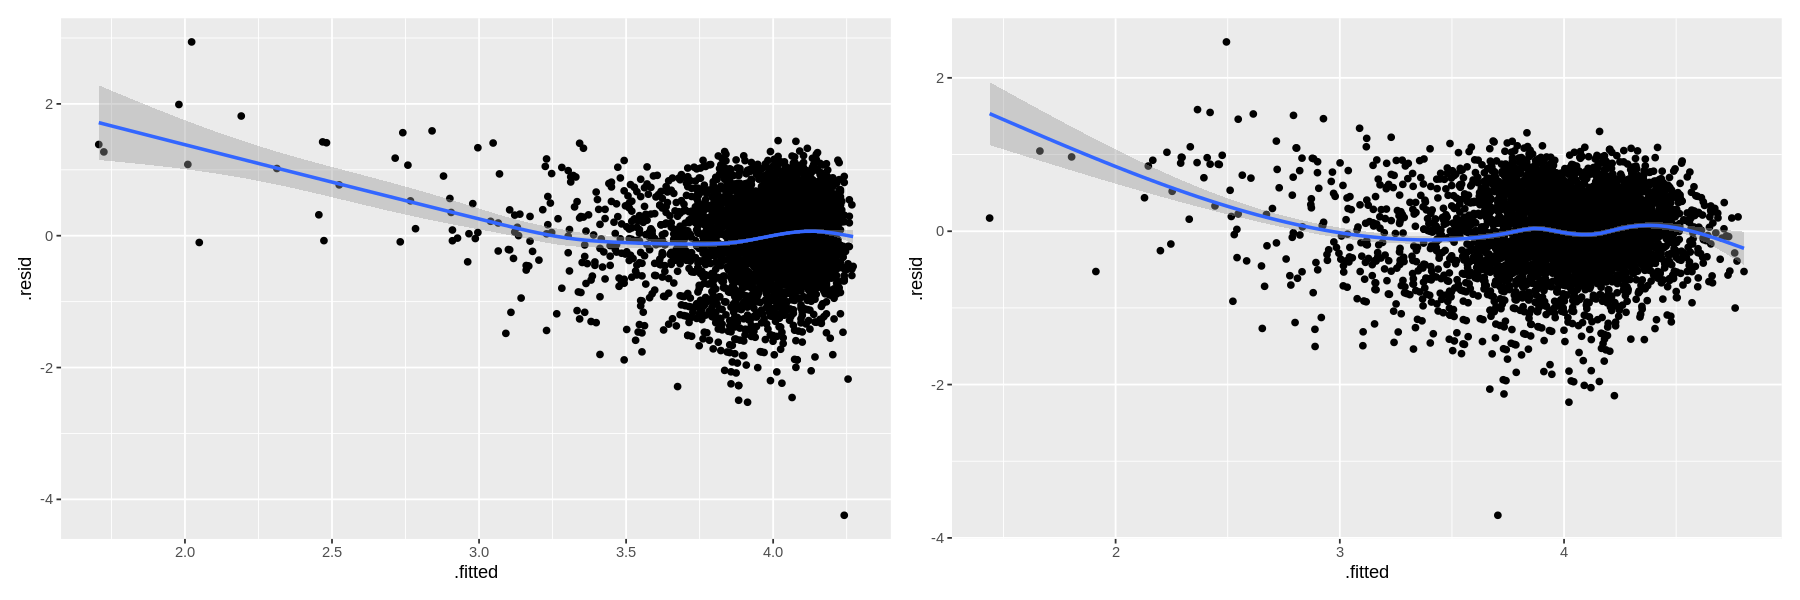

In [ ]:
library(patchwork)
g4 <- ggplot(data = lm4.aug, aes(x = .fitted, y = .resid)) +
  geom_point() +
  geom_smooth()
g1 <- ggplot(data  = lm1.aug, aes(x = .fitted, y = .resid)) +
  geom_point() +
  geom_smooth()

g1 + g4

**Exercise:**  Plot the residuals against the fitted values, using small multiples (**facets**) based on the station number. Does each station's residuals have a mean of 0 and a constant standard deviation? Is the vertical spread of the residuals the same across all measurement stations? Is there any particular station for which the residuals don't look normally distributed with a mean of 0 and constant standard deviation?

**Answer:**

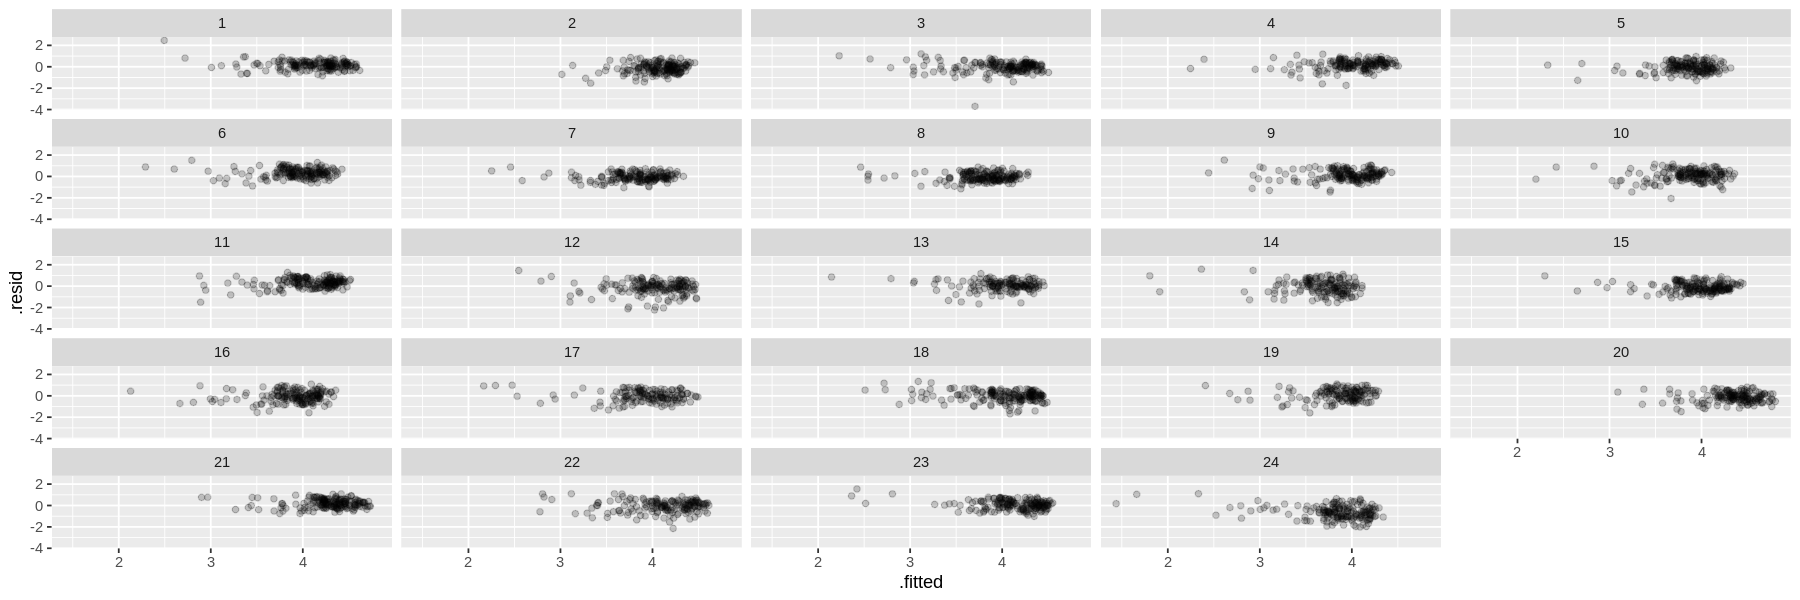

In [ ]:
ggplot(data=lm4.aug, aes(x=.fitted, y=.resid)) +
  geom_point(alpha = 0.2) +
  facet_wrap( ~ Station.ID)

There may be unexplained variation left in the residuals, indicating that our model is not complex enough to capture the variation properly. If a residuals vs fitted plot shows that our residuals have a mean of 0 and a constant standard deviation, then plotting the residuals against any of our explanatory variables should show the same type of trend, a mean of 0 and constant standard deviation.


**Exercise:** Using the augmented data frame you just calculated, select the residuals and the explanatory variables and store them in a new data frame. Create a pairs plot to see if there is any curvature in these residuals when plotted against the other explanatory variables.

**Answer:**

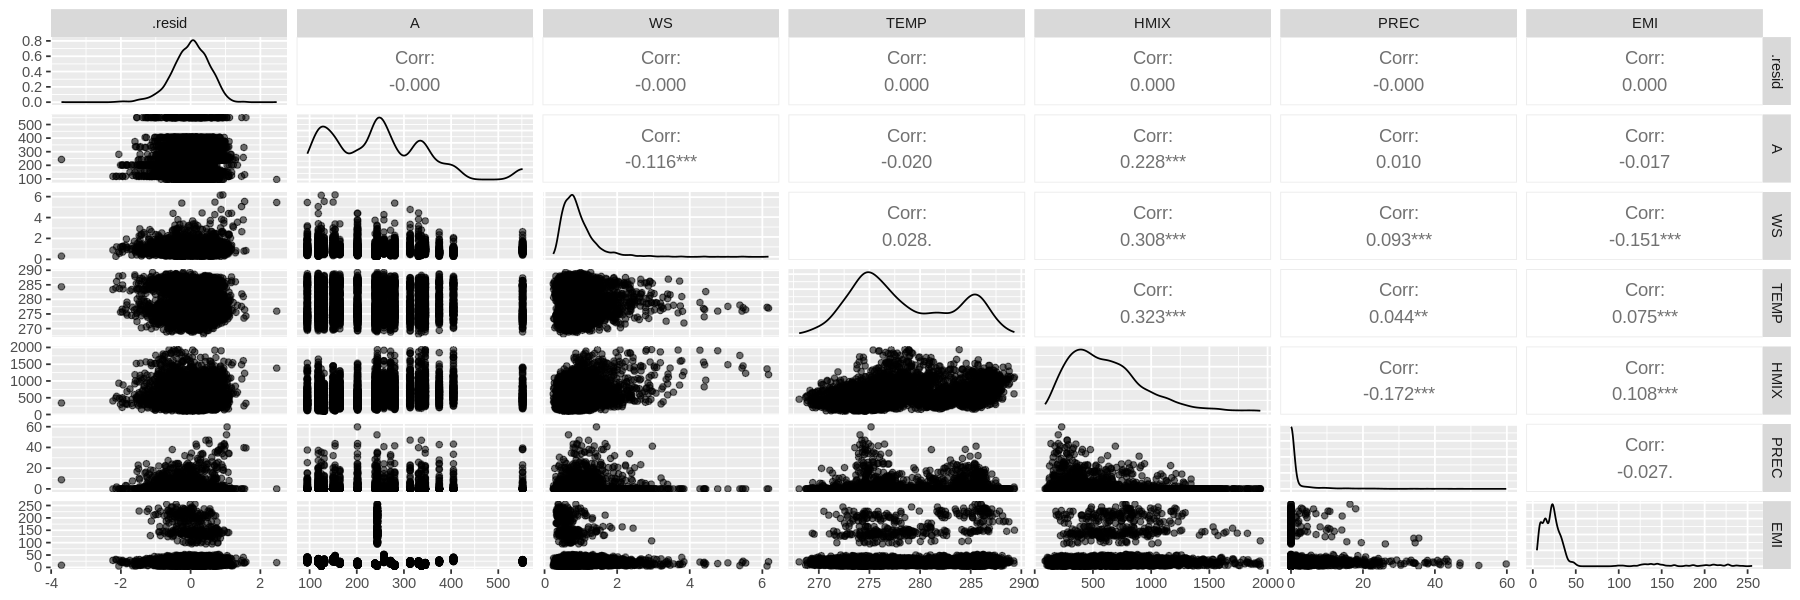

In [ ]:
select(lm4.aug, .resid, A, WS:EMI) %>%
  ggpairs(mapping = aes(alpha = 0.2))


**Exercise:** If you believe there is an explanatory variable where there may still be a relationship with $\text{PM}_{10}$ because the residuals indicate a relationship other than a mean of 0 and constant standard deviation, fit a regression model that includes a polynomial term for that variable. State which variable you have included as a polynomial and perform an $F$ test to determine whether it improves the goodness of fit.

**Answer:**

# References

Bell, Michelle L. 2012. “Assessment of the Health Impacts of Particulate Matter Characteristics.” 161. Health Effects Institute.  
Cameletti, Michela, Finn Lindgren, Daniel Simpson, and Håvard Rue. 2012. “Spatio-Temporal Modeling of Particulate Matter Concentration Through the SPDE Approach.” _Advances in Statistical Analysis_ 97 (2). Springer Nature:109–31. https://doi.org/10.1007/s10182-012-0196-3.  
Hastie, T. J., and D. Pregibon. 1992. “Generalised Linear Models.” In _Statistical Models_ in s, edited by J. M. Chambers and T. J. Hastie. Wadsworth & Brooks/Cole.  
Tibshirani, Robert, Iain Johnstone, Trevor Hastie, and Bradley Efron. 2004. “Least Angle Regression.” _The Annals of Statistics_ 32 (2). Institute of Mathematical Statistics:407–99. https://doi.org/10.1214/009053604000000067.  
Venables, W. N., and B. D. Ripley. 2002. _Modern Applied Statistics with s_. Fourth. New York: Springer. http://www.stats.ox.ac.uk/pub/MASS4.